## Исходные данные


Дано 3 датасета - с данными геологоразведки трёх регионов

 - id — уникальный идентификатор скважины;
 - f0, f1, f2 — три признака точек;
 - product — объём запасов в скважине (тыс. баррелей).

# Задача

**Принять решение, где бурить новую скважину.**

Даны пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Построить модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски техникой Bootstrap.

## Условия задачи 

 - Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
 - При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
 - Бюджет на разработку скважин в регионе — 10 млрд рублей.
 - При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
 - После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

# Ход работы

In [36]:
# данные, необходимые для расчетов проекта

BUDGET = 10**10             # общий бюджет
BAR_INCOME = 45 * 10**4    # доход с барреля по рынку (умножено на 1000, т.к запас в данных дан в тысячах баррелей)

In [1]:
# импорт библиотек

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from scipy import stats as st

In [3]:
# загружаем датасеты

try:
    data_0 = pd.read_csv('geo_data_0')
    data_1 = pd.read_csv('geo_data_1')
    data_2 = pd.read_csv('geo_data_2')
except:
    data_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
    data_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
    data_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

## Обзор данных  

In [4]:
# проверим данные

In [5]:
data_0.head(2)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.22117,105.280062
1,2acmU,1.334711,-0.340164,4.36508,73.037750


In [6]:
data_1.head(2)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261


In [7]:
data_2.head(2)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697


In [8]:
data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [9]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [10]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [11]:
# посмотрим на распределение целегового признака \product\

<AxesSubplot:title={'center':'Распределение сырья региона №1, тыс баррелей'}, ylabel='Frequency'>

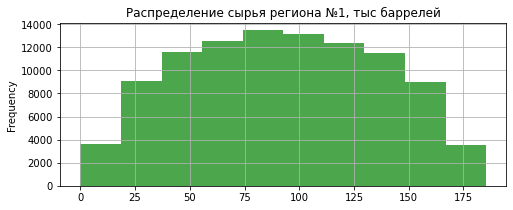

In [12]:
data_0['product'].plot(title='Распределение сырья региона №1, тыс баррелей', 
                       kind='hist', 
                       bins=10,
                       grid=True,
                       figsize=(8,3),
                       color='green',
                       alpha=0.7
                      )

<AxesSubplot:title={'center':'Распределение сырья региона №2, тыс баррелей'}, ylabel='Frequency'>

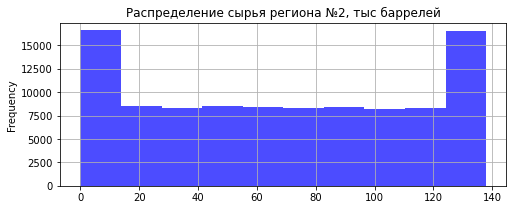

In [13]:
data_1['product'].plot(title='Распределение сырья региона №2, тыс баррелей', 
                       kind='hist', 
                       bins=10,
                       grid=True,
                       figsize=(8,3),
                       color='blue',
                       alpha=0.7
                      )

<AxesSubplot:title={'center':'Распределение сырья региона №3, тыс баррелей'}, ylabel='Frequency'>

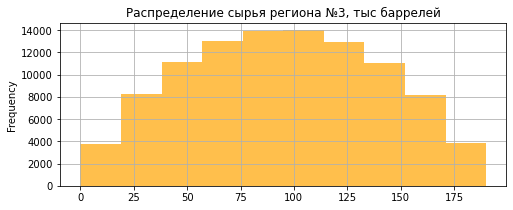

In [14]:
data_2['product'].plot(title='Распределение сырья региона №3, тыс баррелей', 
                       kind='hist', 
                       bins=10,
                       grid=True,
                       figsize=(8,3),
                       color='orange',
                       alpha=0.7
                      )

<div class="alert alert-block alert-info">
    
 - Во втором регионе видно странное распределение сырья - большое его кол-во находится либо на минимуме, либо на максимуме
 - Первый и третий регион показали сходное нормальное распределение
    

In [15]:
# посмотрим на корреляцию признаков

Text(0.5, 1.0, 'Корреляция признаков первого региона')

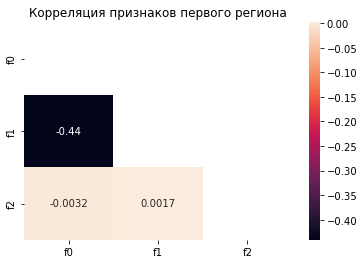

In [16]:
matrix_0 = np.triu(data_0.drop(columns=['id','product']).corr())
sns.heatmap(data_0.drop(columns=['id','product']).corr(), mask=matrix_0, annot = True)
plt.title('Корреляция признаков первого региона')

Text(0.5, 1.0, 'Корреляция признаков второго региона')

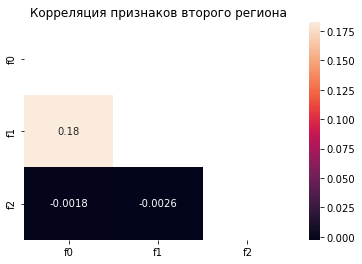

In [17]:
matrix_1 = np.triu(data_1.drop(columns=['id','product']).corr())
sns.heatmap(data_1.drop(columns=['id','product']).corr(), mask=matrix_1, annot = True)
plt.title('Корреляция признаков второго региона')

Text(0.5, 1.0, 'Корреляция признаков третьего региона')

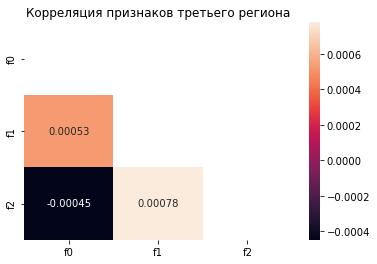

In [18]:
matrix_2 = np.triu(data_2.drop(columns=['id','product']).corr())
sns.heatmap(data_2.drop(columns=['id','product']).corr(), mask=matrix_2, annot = True)
plt.title('Корреляция признаков третьего региона')

<div class="alert alert-block alert-info">
    
    
 - Корреляционная связь признаках во всех регионах достаточно далека от 1 и -1, поэтому можно использовать их все для построения модели
 - Самая сильная корреляционная связь (-0.4) между признаками f0 и f1 в первом регионе

<div class="alert alert-block alert-warning">
    
**ИТОГ ОБЗОРА ДАННЫХ**
    
 - В данных нет пропусков, тип данных соответствует ожидаемому
 - Во втором регионе распределение сырья сосредоточено на минимуме и на максимуме
 - Необходимо проверить данные на наличие дубликатов
 - Для дальнейшей работы линейной регрессии исключим колонку id - чтобы работать только с числовам типом данных
 - В данных для обучения нет сильного разброса - стандартизацию данных можно не выполнять.
 - Показатели корреляции признаков позволяют использовать их все для построения модели

## Предобработка 

In [19]:
# проверка на наличие дубликатов

print('Полные дубликаты в таблицах')
print('1 регион', data_0.duplicated().sum())
print('2 регион', data_1.duplicated().sum())
print('3 регион', data_2.duplicated().sum())

print('\nДубликаты id')
print('1 регион', data_0.shape[0] - data_0['id'].nunique())
print('2 регион', data_1.shape[0] - data_1['id'].nunique())
print('3 регион', data_2.shape[0] - data_2['id'].nunique())

Полные дубликаты в таблицах
1 регион 0
2 регион 0
3 регион 0

Дубликаты id
1 регион 10
2 регион 4
3 регион 4


<div class="alert alert-block alert-info">
    
Необходимо удалить повторяющиеся строчки в колонке id - 10 в первом регионе и по 4 во втором и третьем

In [20]:
# удаление дубликатов

data_0 = data_0.drop_duplicates(subset=['id'], keep='first')
data_1 = data_1.drop_duplicates(subset=['id'], keep='first')
data_2 = data_2.drop_duplicates(subset=['id'], keep='first')

# проверка данных

print('\nДубликаты id')
print('1 регион', data_0.shape[0] - data_0['id'].nunique())
print('2 регион', data_1.shape[0] - data_1['id'].nunique())
print('3 регион', data_2.shape[0] - data_2['id'].nunique())


Дубликаты id
1 регион 0
2 регион 0
3 регион 0


In [21]:
# удаление колонки id

data_0, data_1, data_2 = (
    data_0.drop(columns=['id'], axis=1),
    data_1.drop(columns=['id'], axis=1),
    data_2.drop(columns=['id'], axis=1)
)

In [22]:
# проверим данные

display(data_0.head(2))
display(data_1.head(2))
display(data_2.head(2))

,f0,f1,f2,product
0,0.705745,-0.497823,1.22117,105.280062
1,1.334711,-0.340164,4.36508,73.037750


,f0,f1,f2,product
0,-15.001348,-8.276000,-0.005876,3.179103
1,14.272088,-3.475083,0.999183,26.953261


,f0,f1,f2,product
0,-1.146987,0.963328,-0.828965,27.758673
1,0.262778,0.269839,-2.530187,56.069697


## Подготовка к обучению 

In [23]:
# разделим данные на целевой признак /product/ и признаки для обучения

X_0 = data_0.drop(['product'], axis=1)
y_0 = data_0['product']

X_1 = data_1.drop(['product'], axis=1)
y_1 = data_1['product']

X_2 = data_2.drop(['product'], axis=1)
y_2 = data_2['product']

In [24]:
# радзелим данные каждого датасета на обучающую и валидационную выборки в соотношении 3:1

X0_train, X0_valid, y0_train, y0_valid = train_test_split(X_0, y_0, train_size=0.75, random_state=123)

X1_train, X1_valid, y1_train, y1_valid = train_test_split(X_1, y_1, train_size=0.75, random_state=123)

X2_train, X2_valid, y2_train, y2_valid = train_test_split(X_2, y_2, train_size=0.75, random_state=123)

In [25]:
# проверим полученные данные

print(X0_train.shape)
print(y0_train.shape)
print(X0_valid.shape)
print(y0_valid.shape)

(74992, 3)
(74992,)
(24998, 3)
(24998,)


# Обучение модели

**Будем оценивать работу модели по среднему запасу предсказанного сырья и RMSE модели**

т.к RMSE показывает разницу между прогнозируемыми и фактическими значениями - чем ниже RMSE, тем лучше модель работает.

In [26]:
lr = LinearRegression()

In [27]:
# датасет первого региона

lr.fit(X0_train, y0_train)
predict_0 = lr.predict(X0_valid)
mse_0 = mean_squared_error(y0_valid, predict_0)
rmse_0 = mse_0**0.5

print('Предсказание среднего объёма запасов первого региона - ', predict_0.mean())
print('RMSE первого региона -', rmse_0)

Предсказание среднего объёма запасов первого региона -  92.68062036375521
RMSE первого региона - 37.59580657262362


In [28]:
# датасет второго региона

lr.fit(X1_train, y1_train)
predict_1 = lr.predict(X1_valid)
mse_1 = mean_squared_error(y1_valid, predict_1)
rmse_1 = mse_1**0.5

print('Предсказание среднего объёма запасов второго региона - ', predict_1.mean())
print('RMSE второго региона -', rmse_1)

Предсказание среднего объёма запасов второго региона -  69.31422919477677
RMSE второго региона - 0.8944711936820182


In [29]:
# датасет третьего региона

lr.fit(X2_train, y2_train)
predict_2 = lr.predict(X2_valid)
mse_2 = mean_squared_error(y2_valid, predict_2)
rmse_2 = mse_2**0.5

print('Предсказание среднего объёма третьего региона - ', predict_2.mean())
print('RMSE третьего региона -', rmse_2)

Предсказание среднего объёма третьего региона -  94.93789877099006
RMSE третьего региона - 40.04908749269797


<div class="alert alert-block alert-info">


**Вывод**
 
 - Второй регион показал самую минимальную ошибку предсказаний (1%), но при этом низкий предсказанный объем запасов (69 тыс бар). 
 
 - Первый и третий регионы показали достаточно высокую ошибку (37% и 40%), но при этом достаточно высокий предсказанный объем запасов (92-95 тыс бар).

# Расчет прибыли

## Первичные расчеты 

Чтобы вычислить доход со скважины - необходимо запас сырья в баррелях умножить на средний доход с одного барреля. Чтобы разработка была безубыточной - полученный доход должен превышать наш бюджет. Кроме того, учтем, что для разработки мы используем всего 200 скважин.

*Формула в общем виде на основе среднего будет выглядеть так:* 

**BUDGET = 200 * BAR_INCOME * MEAN_PRODUCT**,  где 
 - BUDGET - бюджет проекта
 - BAR_INCOME - доход с единицы сырья
 - MEAN_PRODUCT - средний объем запасов в одной скважине

In [37]:
# необходимый запас сырья для безубыточной разработки (в тысячах)

need_product = BUDGET  / (200*BAR_INCOME)
print('Необходимый запас сырья -', int(need_product), 'тыс баррелей')

Необходимый запас сырья - 111 тыс баррелей




Для безубыточной разработки необходим запас минимум 111 тыс. баррелей.

Наши регионы показывают следующий средний уровень запасов:

In [38]:
print('1 регион -', int(y_0.mean()), 'тыс баррелей')
print('1 регион -', int(y_1.mean()), 'тыс баррелей')
print('1 регион -', int(y_2.mean()), 'тыс баррелей')

1 регион - 92 тыс баррелей
1 регион - 68 тыс баррелей
1 регион - 94 тыс баррелей



 
Если использовать среднее значение скважин (то есть разрабатывать 200 скважин наугад) - бюджет не окупится. Необходимо разрабатывать только те скважины, которые покажут лучший результат

## Функция расчёта прибыли 

Необходимо вывести формулу, которая:
 - Отберет 200 лучших предсказанных скважин (с самым высоким объемом сырья);
 - Просуммирует общий предсказанный объем сырья в этих скважинах;
 - Рассчитает прибыль от предсказанного сырья 
 
 
Прибыль мы будем считать как:

 **Прибыль = Доход - Бюджет**, где **Доход = Общий объем сырья * Доход одного барреля**

In [39]:
def total_profit(predict_income, price, cost):       # ф-я принимает предсказания, цену барреля и расходы
    
    best_200 = np.sort(predict_income)[::-1][:200]   # сортируем numpy массивы предсказаний и отбираем лучшие 200
    total_barrel = best_200.sum()                    # вычисляем сумму объемов запасов 200 выбраных скважин
    income = total_barrel * price                    # вычисляем доход 200 скважин
    profit = income - cost                           # вычисляем прибыль 
    return profit

In [48]:
# вычислим прибыль для каждого региона в млрд. рублей

profit_0 = total_profit(predict_0, BAR_INCOME, BUDGET)

profit_1 = total_profit(predict_1, BAR_INCOME, BUDGET)

profit_2 = total_profit(predict_2, BAR_INCOME, BUDGET)

print('Предсказанная прибыль от разработки:\n')
print('Первой регион -', int((profit_0) // 10**9), 'млрд. рублей')
print('Второй регион -', int((profit_1) // 10**9), 'млрд. рублей')
print('Третьей регион -', int((profit_2) // 10**9), 'млрд. рублей')

Предсказанная прибыль от разработки:

Первой регион - 3 млрд. рублей
Второй регион - 2 млрд. рублей
Третьей регион - 3 млрд. рублей


## Риски и прибыль 

Вычисленная выше прибыль:
1. Не учитывает риски ошибок,
2. Не учитывает важное условие - раведка производится только на 500 скважинах, из которых мы затем выбираем 200 лучших
3. Построена на предсказаниях модели, а не на реальных данных

### Средняя прибыль по Bootstrap

Чтобы приблизиться к более реалистичным результатам используем технику Bootstrap с 1000 выборок при обучении модели для каждого региона.

Для этого напишем функцию, которая:
 - Примет на вход признаки для обучения и целевые признаки
 - Разделит их на обучающую и валидационную выборку
 - Обучит модель линейной регрессии *обучение проходит по полному пакету данных для более высокого качества*
 - В цикле пройдет по 1000 подвыборкам и сохранит среднюю прибыль каждой подвыборки в список:
    - Из валидационной выборки возьмет 500 скважин случайным образом и для признаков обучения, и для целевых признаков, *причем в целевом признаке сбросит предыдущую индексацию для дальнейшей работы*
    - Построит предсказание на основе 500 скважин и отсортирует их по возрастанию кол-ва сырья
    - В таком же порядке, как и предсказания (по тем же индексам) отсортирует целевые признаки - чтобы затем выбрать именно те 200 скважин, которые модель предсказала как самые богатые по сырью. Таким образом мы сможем узнать реальную, а не предсказанную прибыль.
    - Используем функцию для вычисления прибыли, которую мы использовали ранее, дав ей на вход не предсказания, а реальные целевые признаки
    
 - Функция вернет список прибыли в млн рублей по всем 1000 выборкам   

In [54]:
def predict_profit(X, y): 
    
    state = np.random.RandomState(123)
    profit_list = [] # список с прибылью по каждой подвыборке
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.75, random_state=123)
    lr.fit(X_train, y_train)

    for i in range(1000):
        
        X500 = X_valid.sample(500, replace=True, random_state=state)   # выбираем 500 скважин на валидоционной выборке-признаки
        y500 = y_valid[X500.index].reset_index(drop=True)              # выбираем соответствующие целевые признаки (по индексам)
                                     
        predict = lr.predict(X500)                                        # предсказываем сырье
        predict = pd.Series(predict).sort_values(ascending=False)[:200]   # сортируем по убыванию
        prod200 = y500[predict.index]                                     # проставляем индексы в целевом признаке, 
                                                                          # как в предсказании
        profit = total_profit(prod200, BAR_INCOME, BUDGET) / 10**6        # вычисляем прибыль в млн рублей             
        profit_list.append(profit)
    
    return pd.Series(profit_list)

In [55]:
# вычислим прибыль для каждого региона

profit_list_0 = predict_profit(X_0,y_0)
profit_0 = sum(profit_list_0) / len(profit_list_0)

profit_list_1 = predict_profit(X_1,y_1)
profit_1 = sum(profit_list_1) / len(profit_list_1)

profit_list_2 = predict_profit(X_2,y_2)
profit_2 = sum(profit_list_2) / len(profit_list_2)

In [56]:
print('Средняя прибыль первого региона - ', int(profit_0), 'млн рублей')
print('Средняя прибыль второго региона - ', int(profit_1), 'млн рублей')
print('Средняя прибыль третьего региона - ', int(profit_2), 'млн рублей')

Средняя прибыль первого региона -  394 млн рублей
Средняя прибыль второго региона -  488 млн рублей
Средняя прибыль третьего региона -  344 млн рублей


<div class="alert alert-block alert-info">


Как мы видим, разница в предсказанных и реальных показателях достаточно внушительная:
 - 1 и 3 регион - 2.5 млрд
 - 2 регион - 1.5 млрд

### Доверительный интервал 

Вычислим 95% доверительный интервал - в нем с верятностью 95% будет находиться нужное нам среднее прибыли.

In [57]:
# первый регион

interval_0 = st.t.interval(0.95, len(profit_list_0)-1, profit_0, profit_list_0.sem())
interval_0

(378.6734054307905, 411.00935948199555)

In [58]:
# второй регион

interval_1 = st.t.interval(0.95, len(profit_list_1)-1, profit_1, profit_list_1.sem())
interval_1

(475.58422661436816, 501.2235429548932)

In [59]:
# третий регион

interval_2 = st.t.interval(0.95, len(profit_list_2)-1, profit_2, profit_list_2.sem())
interval_2

(327.14555867360514, 361.18179711372113)

<div class="alert alert-block alert-info">


 - Самую максимальную прибыль показал второй регион.
 - На втором месте первый регион, в третьем регионе прибыль меньше всего.

### Риски 

<div class="alert alert-block alert-info">


 - Для оценки рисков посмотрим, нет ли в полученных результатах отрицательной прибыли (убытка) и в каком соотношении она есть.
 - Кроме того, вычислим 2.5% квантиль прибыли, чтобы узнать своеобразную 'минимальную' прибыль - если он окажется отрицательным, регион точно не подходит для добычи. 
 - А также вычислим 97.5% квантиль, чтобы оценить максимальную прибыль региона

Для упрощения работы составим функцию - она примет на вход список с полученной ранее прибылью, а вернет 2.5% квантиль и риск как соотношение отрицательных единиц прибыли к общему числу единиц прибыли.

In [67]:
def risk(series):
    q_025 = series.quantile(0.025)       # сохраняем значение 2.5% квантиля
    q_975 = series.quantile(0.975)      # сохраняем значение 97.5% квантиля
    
    count = 0
    for p in series:                     # в цикле проходим по всем значениям прибыли и увеличиваем счетчик,
        if p <= 0:                       # если она отрицательна
            count +=1
    risk = count / len(series)           # считаем уровень риска 
    
    return q_025, q_975, risk*100

In [71]:
#ячейка ревьюера

display(pd.Series([-2, -1, 4, 5]))
'Риск убытков = {:.2%} '.format((pd.Series([-2, -1, 4, 5])<0).mean())

0   -2
1   -1
2    4
3    5
dtype: int64

'Риск убытков = 50.00% '

In [77]:
# первый регион

q0_min, q0_max, risk_0 = risk(profit_list_0)

print('2,5% квантиль первого региона -', int(q0_min), 'млн')
print('97,5% квантиль первого региона -', int(q0_max), 'млн')
print('Риск первого региона -', risk_0, '%')

2,5% квантиль первого региона - -131 млн
97,5% квантиль первого региона - 900 млн
Риск первого региона - 6.7 %


In [76]:
# второй регион

q1_min, q1_max, risk_1 = risk(profit_list_1)

print('2,5% квантиль второго региона -', int(q1_min), 'млн')
print('97,5% квантиль второго региона -', int(q1_max), 'млн')
print('Риск второго региона -', risk_1, '%')

2,5% квантиль второго региона - 79 млн
97,5% квантиль второго региона - 883 млн
Риск второго региона - 0.8 %


In [79]:
# третий регион

q2_min, q2_max, risk_2 = risk(profit_list_2)

print('2,5% квантиль первого региона -', int(q2_min), 'млн')
print('97,5% квантиль первого региона -', int(q2_max), 'млн')
print('Риск первого региона -', risk_2, '%')

2,5% квантиль первого региона - -209 млн
97,5% квантиль первого региона - 840 млн
Риск первого региона - 10.7 %


<div class="alert alert-block alert-info"> 
    
 - Первый и третий регионы в 2.5% квантиле показали отрицательную прибыль и, соответственно, самый высокий уровень риска. 
 - Второй регион показал уровень риска чуть менее 1%, его минимальная прибыль составит 79 млн рублей, а максимальная - 883 млн

# Общий вывод

<div class="alert alert-block alert-warning">


**ПОДЫТОЖИМ РЕЗУЛЬТАТЫ**

**Ошибка модели**

При обучении и предсказании модели мы получили следующий RMSE по регионам (разницу между прогнозируемыми и фактическими значениями - условно ошибку в предсказании):

 - 1 регион - 37
 - 2 регион - 0.9
 - 3 регион - 40


**Запас одной скважины**

Необходимый средний запас сырья в скважине для окупаемости - 111 тыс баррелей

Регионы показали следующий средний уровень запасов по предсказанию:
 - 1 регион - 92 тыс
 - 2 регион - 68 тыс
 - 3 регион - 94 тыс

*Если использовать среднее значение скважин (то есть разрабатывать 200 скважин наугад) - бюджет не окупится. Необходимо разрабатывать только те скважины, которые покажут лучший результат*
    
    
**Общая прибыль**

Предсказанная прибыль от разработки:

 - 1 регион - 3 млрд. рублей
 - 2 регион - 2 млрд. рублей
 - 3 регион - 3 млрд. рублей

Реальная средняя прибыль:

  - 1 регион - 394 млн рублей
  - 2 регион - 482 млн рублей
  - 3 регион - 344 млн рублей
  
*Как мы видим, разница в предсказанных и реальных показателях достаточно значительная: для 1 и 3 регион - 2.5 млрд, для 2 региона - 1.5 млрд*
    

**Риски и минимальные прибыли**

 - Первый и третий регион показали риск убытков в 6% и 10% соответственно, в них возможны убытки - с вероятностью 2.5% прибыль будет на уровне минус 130 и 200 млн рублей для каждого региона.
 - Второй регион имеет риск чуть менее 1%, его минимальная прибыль 79 млн рублей
    
    
**РЕКОМЕНДАЦИИ**
 
Лучшие показатели продемонстрировал второй регион.
    
  Положительные стороны региона:
 - минимальная ошибка при предсказании модели (RMSE) - менее 1%
 - минимальный риск убытков - менее 1%
 - средний уровень прибыли 482 млн рублей ('минимум' - 79 млн, 'максимум' - 883 млн) 
    
  На что стоит обратить внимание:
 - в распределении кол-ва сырья выделяется его большое скопление на минимуме и максимуме, кроме того, реальный средний уровень сырья в скважине меньше, чем нужно для безубыточной работы - поэтому необходима хорошая работа модели для предсказания скважин, чтобы выбирать лучшие для разработки с минимальной ошибкой (сейчас доля ошибки минимальна).
 
*Таким образом, предпочтительней остановить свой выбор на втором регионе разработки*